In [1]:
# libraries for working with our data
# https://datadrivenmoney.com/simulate-dollar-cost-averaging-with-python/
import pandas as pd
import numpy as np
import yfinance as yf
import datetime

# libraries for plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Use Pandas to reformat columns to be displayed as currency
pd.options.display.float_format = '{:6.2f}'.format

In [2]:
# first, we need to get a hold of the appropriate data
# so we can eventually simulate our dollar cost average method
data = yf.download(

        # download only the tickers we want
        # In this example I will use 'SPY' which
        # attempts to track the performance of the S&P 500
        tickers = "SPY",

        # What period of time are we interested in?
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # In our case we will choose 10y
        period = "5y",

        # Next we need to define our interval.
        interval = "1d",

        # Ensure our data is grouped properly.
        group_by = 'ticker',
)

# take a peek at our data
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-04-05,236.26,237.39,234.54,234.78,215.15,108800600
2017-04-06,234.94,236.04,234.43,235.44,215.75,69135800
2017-04-07,235.15,236.00,234.64,235.20,215.53,74412300
2017-04-10,235.36,236.26,234.73,235.34,215.66,67615300
2017-04-11,234.90,235.18,233.34,235.06,215.40,88045300


In [3]:
# now we need to define the parameters of our dollar cost average

# the starting principal
p = 10000

# the amount to dollar cost average per month
monthly_add = 500

# starting date
starting_year = 2017
starting_month = 1

# ending date
ending_year = 2021
ending_month = 12

In [4]:
# calculate the number of periods (number of months for the excercise)
periods = (ending_year - starting_year - 1) * 12 + (ending_month - starting_month + 1)

# create a date variable based on starting year and month above
starting_date = str(starting_year)+'-'+str(starting_month)+'-01'

# use starting_date and number of periods (months) to create a series of all
# contribution dates
contribution_dates = pd.Series(pd.date_range(str(starting_date), freq="M", periods=periods))
contribution_dates.head()

0   2017-01-31
1   2017-02-28
2   2017-03-31
3   2017-04-30
4   2017-05-31
dtype: datetime64[ns]

In [5]:
# quickly print out all contribution dates that were not trading days
for i in range(len(contribution_dates)):
  if contribution_dates[i] not in data.index:
    print(contribution_dates[i], contribution_dates[i].day_name())

2017-01-31 00:00:00 Tuesday
2017-02-28 00:00:00 Tuesday
2017-03-31 00:00:00 Friday
2017-04-30 00:00:00 Sunday
2017-09-30 00:00:00 Saturday
2017-12-31 00:00:00 Sunday
2018-03-31 00:00:00 Saturday
2018-06-30 00:00:00 Saturday
2018-09-30 00:00:00 Sunday
2019-03-31 00:00:00 Sunday
2019-06-30 00:00:00 Sunday
2019-08-31 00:00:00 Saturday
2019-11-30 00:00:00 Saturday
2020-02-29 00:00:00 Saturday
2020-05-31 00:00:00 Sunday
2020-10-31 00:00:00 Saturday


In [6]:
# If the day is not a trading day then move it one day previous and store
for i in range(len(contribution_dates)):
  # 土日を考慮して2回戻す
  if contribution_dates[i] not in data.index:
    contribution_dates[i] = contribution_dates[i] - pd.Timedelta("1 day")
  if contribution_dates[i] not in data.index:
    contribution_dates[i] = contribution_dates[i] - pd.Timedelta("1 day")
    
# Once again print out the dates to see how we did
for i in range(len(contribution_dates)):
  if contribution_dates[i] not in data.index:
    print(contribution_dates[i], contribution_dates[i].day_name(), i)
    contribution_dates = contribution_dates.drop(i)

2017-01-29 00:00:00 Sunday 0
2017-02-26 00:00:00 Sunday 1
2017-03-29 00:00:00 Wednesday 2


In [7]:
# Establish new columns with our starting principal, number of shares
# Current Value of our shares, the running return of the selected security
# and the Dollar Cost Averaging Running Return
data['Shares'] = p / data.loc[contribution_dates.iloc[0], 'Adj Close']
data['Principal'] = p
data['CurrentValue'] = p
data['BenchmarkReturn'] = 0
data['DCAReturn'] = 0

for i in range(1, len(data.loc[contribution_dates])):
  # Calculate the number of Shares added by the contribution and add to previous month's amount
  data.loc[contribution_dates.iloc[i], 'Shares']  = data.loc[contribution_dates.iloc[i-1], 'Shares'] + (monthly_add / data.loc[contribution_dates.iloc[i], 'Adj Close'])

  # Add the monthly contribution at the beginning of each month to the principal
  data.loc[contribution_dates.iloc[i], 'Principal']  = data.loc[contribution_dates.iloc[i-1], 'Principal'] + monthly_add

  # Use the present value of the security to find the total value of all shares owned
  data.loc[contribution_dates.iloc[i], 'CurrentValue']  = data.loc[contribution_dates.iloc[i], 'Shares'] * data.loc[contribution_dates.iloc[i], 'Adj Close']

  # Calculate the running return of the security based on the current month's price (iterative)
  data.loc[contribution_dates.iloc[i], 'BenchmarkReturn'] = (data.loc[contribution_dates.iloc[i], 'Adj Close'] - data.loc[contribution_dates.iloc[0], 'Adj Close'])/data.loc[contribution_dates.iloc[0], 'Adj Close']*100

  # Calculate the running return of the DCA balance on the current month's price (iterative)
  data.loc[contribution_dates.iloc[i], 'DCAReturn'] = (data.loc[contribution_dates.iloc[i], 'CurrentValue'] - data.loc[contribution_dates.iloc[i], 'Principal'])/data.loc[contribution_dates.iloc[i], 'Principal']*100

# Create a new DataFrame that only has rows corresponding to the contribution dates
monthly_data = data.loc[contribution_dates]

# Print out the last 5 months worth of results
monthly_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Shares,Principal,CurrentValue,BenchmarkReturn,DCAReturn
Date,,,,,,,,,,,
2020-08-31,350.35,351.30,349.06,349.31,340.82,66099200,121.46,30000,41394.91,56.22,37.98
2020-09-30,333.09,338.29,332.88,334.89,328.06,104081100,122.98,30500,40344.94,50.37,32.28
2020-10-30,328.28,329.69,322.60,326.54,319.88,120287300,124.54,31000,39838.99,46.62,28.51
2020-11-30,362.83,363.12,359.17,362.06,354.68,83872700,125.95,31500,44672.56,62.57,41.82
2020-12-31,371.78,374.66,371.23,373.88,367.82,78520700,127.31,32000,46827.60,68.59,46.34


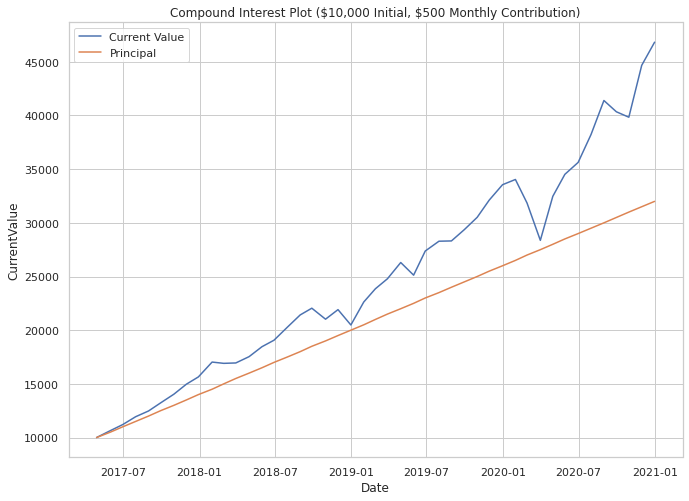

In [8]:
plot_data = monthly_data

# Now Let's go ahead and plot it out
sns.set(rc={'figure.figsize':(11,8)}) # Change the size of the plot
sns.set_style('whitegrid') # Change the default background
plt.ticklabel_format(style='plain', axis = 'y') # prevent sci notation on y-axis

# now for the actual plot
sns.lineplot(data = plot_data, x= 'Date', y = 'CurrentValue')
sns.lineplot(data = plot_data, x= 'Date', y = 'Principal').set_title('Compound Interest Plot (\$10,000 Initial, \$500 Monthly Contribution)')
plt.legend(labels=["Current Value","Principal"])

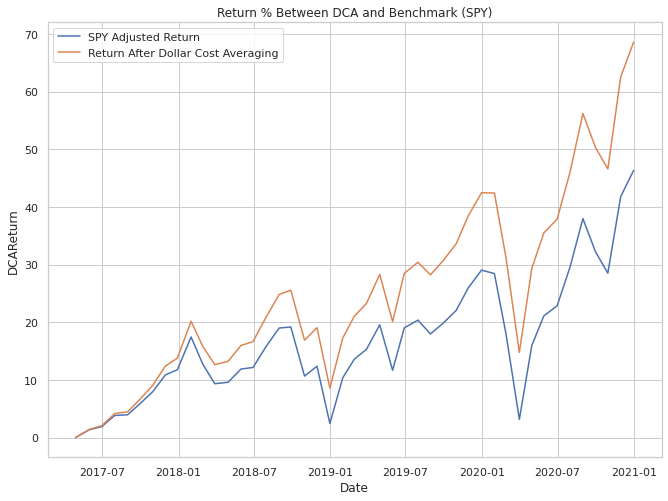

In [9]:
sns.lineplot(data = plot_data, x= 'Date', y = 'DCAReturn')
sns.lineplot(data = plot_data, x= 'Date', y = 'BenchmarkReturn').set_title('Return % Between DCA and Benchmark (SPY)')
plt.legend(labels=["SPY Adjusted Return","Return After Dollar Cost Averaging"])